In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('felixstowe_rotterdam.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
0,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.31,1.2,264.0,297.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
1,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.31,2.3,285.0,293.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
2,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,4.6,280.0,262.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
3,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,3.7,251.0,218.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
4,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,3.8,210.0,180.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001


In [4]:
ais_nan = ais

In [5]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [6]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [7]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [8]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [9]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [10]:
# Set invalid breadths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [11]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [12]:
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

Text(0.5,1,u'All Positions Before Filtering')

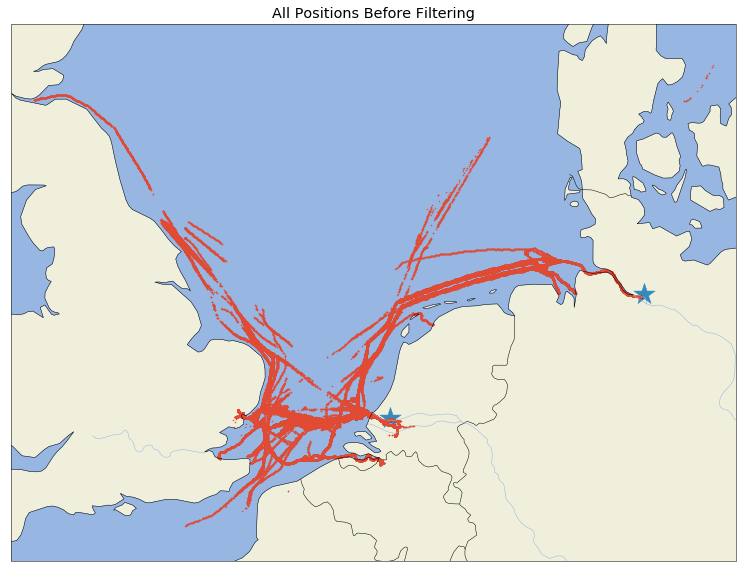

In [40]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

In [14]:
# Plot start positions before any filtering to map
#aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
#plt.title("Start Positions Before Filtering")

In [15]:
# Plot end positions before any filtering to map
#aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
#plt.title("End Positions Before Filtering")

In [16]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 0.97) | (ais_dropped['Longitude'] > 4.8)
outside_lat_mask = (ais_dropped['Latitude'] < 51.62) | (ais_dropped['Latitude'] > 52.3)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

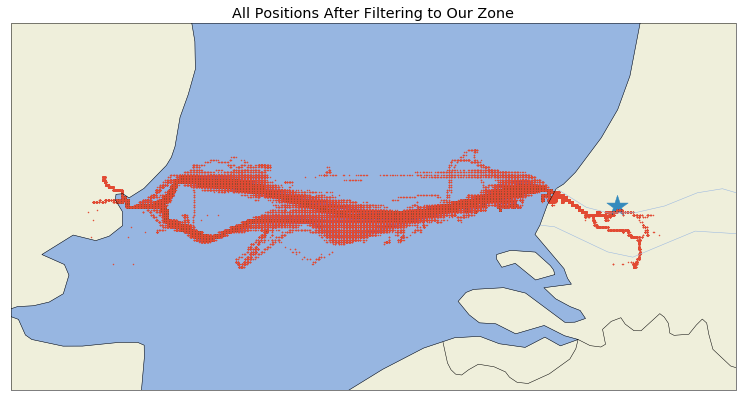

In [41]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

In [18]:
#minlat = ais_zoned['EndLatitude'].min() - 0.2
#maxlat = ais_zoned['EndLatitude'].max() + 0.2
#minlong = ais_zoned['EndLongitude'].min() - 0.2
#maxlong = ais_zoned['EndLongitude'].max() + 0.2

#aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
#plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [19]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 3.94].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

C:\Users\eijoa\Anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


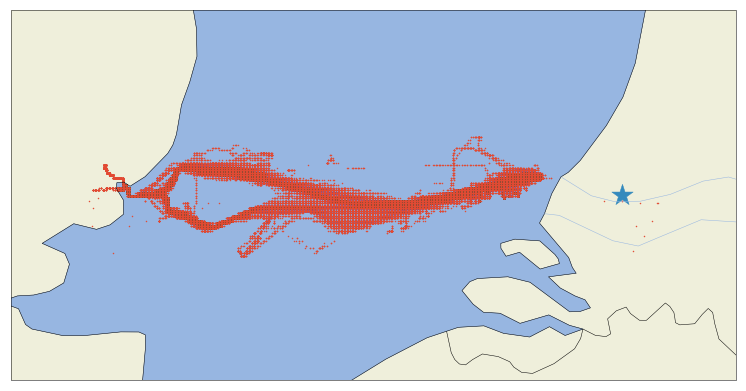

In [42]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [21]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

In [22]:
#travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
#travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
#travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

In [23]:
#travel_times[travel_times < travel_times.quantile(.75)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [24]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[(ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.90)) & (ais_tts['TravelTimeMins'] > 270)]

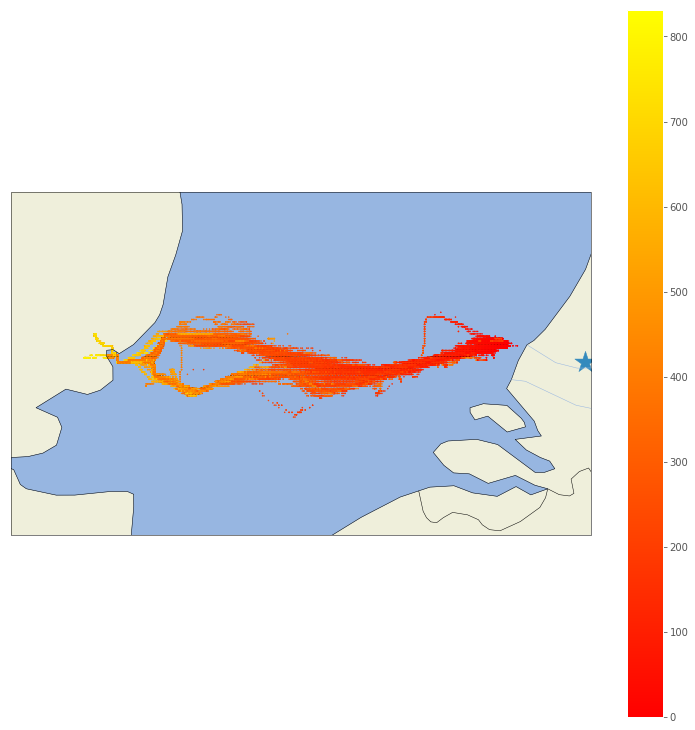

In [44]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [26]:
# Get and plot the longest trip in the data set
#longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
#longest_trip.head()

In [27]:
#aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
#plt.title("Longest Trip in the Data Set")

In [28]:
ais_tfeats = ais_shortmaj
ais_tfeats.is_copy = False

ais_tfeats['hour_of_day'] = ais_tfeats['time'].dt.hour
ais_tfeats['weekday'] = ais_tfeats['time'].dt.dayofweek
ais_tfeats['day_of_month'] = ais_tfeats['time'].dt.day
ais_tfeats['month'] = ais_tfeats['time'].dt.month

In [29]:
ais_interpol = ais_tfeats.copy()
ais_interpol.index = ais_interpol['time']
ais_interpol = ais_interpol.groupby('TripID').apply(lambda x : x.resample('T').mean().interpolate(method='linear')).reset_index()

In [30]:
#ais_tfeats.groupby('weekday')['TravelTimeMins'].mean().plot(figsize = (15, 5))

In [31]:
# Assign sector IDs according to Longitude ranges (3 sectors for FEL-ROT route)
def assign_sectors(ais_before):
    ais_after = ais_before.copy()
    
    ais_after.loc[(ais_after['Longitude'] <= 2.2) , 'sector'] = '0'
    ais_after.loc[(ais_after['Longitude'] <= 3.2) & (ais_after['Longitude'] > 2.2), 'sector'] = '1'
    ais_after.loc[(ais_after['Longitude'] <= 3.94) & (ais_after['Longitude'] > 3.2), 'sector'] = '2'
    ais_after.loc[ais_after['Longitude'] > 3.94, 'sector'] = np.nan
    
    return ais_after

ais_sectors = assign_sectors(ais_tfeats)

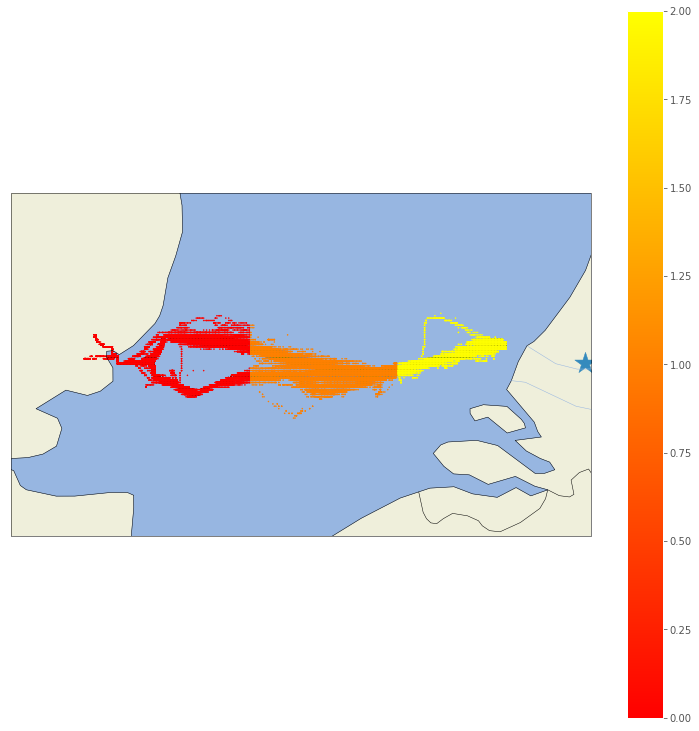

In [45]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_sectors['Longitude'], latitude = ais_sectors['Latitude'], col = ais_sectors['sector'])

In [33]:
ais_secleav = ais_sectors.copy()
ais_secleav = ais_secleav.sort_values('time')

ais_secleav['next_lat'] = ais_secleav.groupby('TripID')['Latitude'].shift(-1)
ais_secleav['next_lon'] = ais_secleav.groupby('TripID')['Longitude'].shift(-1)
ais_secleav['next_time'] = ais_secleav.groupby('TripID')['time'].shift(-1)
ais_secleav['next_sog'] = ais_secleav.groupby('TripID')['SOG'].shift(-1)
ais_secleav['next_cog'] = ais_secleav.groupby('TripID')['COG'].shift(-1)
ais_secleav['next_sector_id'] = ais_secleav.groupby('TripID')['sector'].shift(-1)
ais_secleav = ais_secleav.sort_values(['TripID', 'time'])
ais_secleav['next_trip_id'] = ais_secleav['TripID'].shift(-1)

lasts = ais_secleav[ais_secleav['sector'] != ais_secleav['next_sector_id']]

lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] = 2.2
lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] = 3.2
lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] = 3.94


lasts.loc[lasts['sector'] == '0', 'sector_leave_lat'] = lasts.loc[lasts['sector'] == '0', 'Latitude'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_lat'] = lasts.loc[lasts['sector'] == '1', 'Latitude'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_lat'] = lasts.loc[lasts['sector'] == '2', 'Latitude'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])

lasts.loc[lasts['sector'] == '0', 'sector_leave_time'] = lasts.loc[lasts['sector'] == '0', 'time'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_time'] - lasts.loc[lasts['sector'] == '0', 'time'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_time'] = lasts.loc[lasts['sector'] == '1', 'time'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_time'] - lasts.loc[lasts['sector'] == '1', 'time'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_time'] = lasts.loc[lasts['sector'] == '2', 'time'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_time'] - lasts.loc[lasts['sector'] == '2', 'time'])

lasts.loc[lasts['sector'] == '0', 'sector_leave_sog'] = lasts.loc[lasts['sector'] == '0', 'SOG'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_sog'] - lasts.loc[lasts['sector'] == '0', 'SOG'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_sog'] = lasts.loc[lasts['sector'] == '1', 'SOG'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_sog'] - lasts.loc[lasts['sector'] == '1', 'SOG'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_sog'] = lasts.loc[lasts['sector'] == '2', 'SOG'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_sog'] - lasts.loc[lasts['sector'] == '2', 'SOG'])

lasts.loc[lasts['sector'] == '0', 'sector_leave_cog'] = lasts.loc[lasts['sector'] == '0', 'COG'] + ((lasts.loc[lasts['sector'] == '0', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude']) / (lasts.loc[lasts['sector'] == '0', 'next_lon'] - lasts.loc[lasts['sector'] == '0', 'Longitude'])) * (lasts.loc[lasts['sector'] == '0', 'next_cog'] - lasts.loc[lasts['sector'] == '0', 'COG'])
lasts.loc[lasts['sector'] == '1', 'sector_leave_cog'] = lasts.loc[lasts['sector'] == '1', 'COG'] + ((lasts.loc[lasts['sector'] == '1', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude']) / (lasts.loc[lasts['sector'] == '1', 'next_lon'] - lasts.loc[lasts['sector'] == '1', 'Longitude'])) * (lasts.loc[lasts['sector'] == '1', 'next_cog'] - lasts.loc[lasts['sector'] == '1', 'COG'])
lasts.loc[lasts['sector'] == '2', 'sector_leave_cog'] = lasts.loc[lasts['sector'] == '2', 'COG'] + ((lasts.loc[lasts['sector'] == '2', 'sector_leave_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude']) / (lasts.loc[lasts['sector'] == '2', 'next_lon'] - lasts.loc[lasts['sector'] == '2', 'Longitude'])) * (lasts.loc[lasts['sector'] == '2', 'next_cog'] - lasts.loc[lasts['sector'] == '2', 'COG'])

ais_secleav['sector_leave_lat'] = lasts['sector_leave_lat']
ais_secleav['sector_leave_lon'] = lasts['sector_leave_lon']
ais_secleav['sector_leave_time'] = lasts['sector_leave_time']
ais_secleav['sector_leave_sog'] = lasts['sector_leave_sog']
ais_secleav['sector_leave_cog'] = lasts['sector_leave_cog']

ais_secleav['sector_leave_lat'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_lat'].transform('last')
ais_secleav['sector_leave_lon'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_lon'].transform('last')
ais_secleav['sector_leave_time'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_time'].transform('last')
ais_secleav['sector_leave_sog'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_sog'].transform('last')
ais_secleav['sector_leave_cog'] = ais_secleav.groupby(['TripID', 'sector'])['sector_leave_cog'].transform('last')

ais_secleav = ais_secleav.drop(['next_lat', 'next_lon', 'next_time', 'next_sog', 'next_cog', 'next_sector_id', 'next_trip_id'], axis = 1)

C:\Users\eijoa\Anaconda2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [34]:
ais_secleav_ts = ais_secleav.copy()
ais_secleav_ts['time_to_sector_leave'] = ais_secleav_ts['sector_leave_time'] - ais_secleav_ts['time']
ais_secleav_ts['mins_to_sector_leave'] = ais_secleav_ts['time_to_sector_leave'].transform(lambda x: x.total_seconds() / 60)

In [35]:
ais_secleav_ts.columns

Index([u'TripID', u'StartLatitude', u'StartLongitude', u'StartTime',
       u'EndLatitude', u'EndLongitude', u'EndTime', u'time', u'Length',
       u'Breadth', u'Draught', u'Latitude', u'Longitude', u'SOG', u'COG',
       u'TH', u'Destination', u'Callsign', u'TravelTime', u'TravelTimeMins',
       u'remainingTT', u'remainingMins', u'hour_of_day', u'weekday',
       u'day_of_month', u'month', u'sector', u'sector_leave_lat',
       u'sector_leave_lon', u'sector_leave_time', u'sector_leave_sog',
       u'sector_leave_cog', u'time_to_sector_leave', u'mins_to_sector_leave'],
      dtype='object')

In [36]:
learners = ['TripID', 'time', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
            'SOG', 'COG', 'TH', 'TravelTimeMins', 'remainingMins', 'hour_of_day',
            'weekday', 'day_of_month', 'month', 'sector', 'mins_to_sector_leave', 'sector_leave_lat',
            'sector_leave_lon', 'sector_leave_sog', 'sector_leave_cog']

In [37]:
ais_learners = ais_secleav_ts[learners]
ais_learners = ais_learners.dropna()
ais_learners.head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,...,hour_of_day,weekday,day_of_month,month,sector,mins_to_sector_leave,sector_leave_lat,sector_leave_lon,sector_leave_sog,sector_leave_cog
336698,1000064,2016-03-14 23:40:00,82.0,11.0,3.04,52.03,1.69,8.1,88.0,76.0,...,23,0,14,3,0,136.615385,52.0,2.2,9.130769,99.1
336699,1000064,2016-03-14 23:41:00,82.0,11.0,3.04,52.03,1.70,8.2,88.1,77.0,...,23,0,14,3,0,135.615385,52.0,2.2,9.130769,99.1
336700,1000064,2016-03-14 23:42:00,82.0,11.0,3.04,52.03,1.70,8.3,90.1,78.0,...,23,0,14,3,0,134.615385,52.0,2.2,9.130769,99.1
336701,1000064,2016-03-14 23:43:00,82.0,11.0,3.04,52.03,1.70,8.5,88.7,76.0,...,23,0,14,3,0,133.615385,52.0,2.2,9.130769,99.1
336533,1000064,2016-03-14 23:44:00,82.0,11.0,3.04,52.03,1.71,8.2,87.9,77.0,...,23,0,14,3,0,132.615385,52.0,2.2,9.130769,99.1


In [38]:
def save_by_sectors(ais_data, name):
    sectors = ais_data['sector'].unique()
    for s in sectors:
        ais_to_save = ais_data[ais_data['sector'] == s]
        ais_to_save.to_pickle('%s_s%s.pkl' % (name, s))

In [39]:
# Export without downsampling
ais_learners = ais_secleav_ts[learners]
ais_learners = ais_learners.dropna()
save_by_sectors(ais_learners, 'FEL-ROT_learners_01min')

In [ ]:
# Export downsampled to 5 minutes
ais_downsampled = ais_secleav_ts.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('5T').mean()).reset_index()
ais_downsampled = assign_sectors(ais_downsampled)

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('FEL-ROT_learners_05min.pkl')

In [ ]:
# Export downsampled to 10 minutes
ais_downsampled = ais_secleav_ts.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('10T').mean()).reset_index()
ais_downsampled = assign_sectors(ais_downsampled)

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
save_by_sectors(ais_learners, 'FEL-ROT_learners_10min')

In [ ]:
# Export downsampled to 15 minutes
ais_downsampled = ais_secleav_ts.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('15T').mean()).reset_index()
ais_downsampled = assign_sectors(ais_downsampled)

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('FEL-ROT_learners_15min.pkl')

In [ ]:
# Export downsampled to 30 minutes
ais_downsampled = ais_secleav_ts.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('30T').mean()).reset_index()
ais_downsampled = assign_sectors(ais_downsampled)

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('FEL-ROT_learners_30min.pkl')

In [ ]:
# Export downsampled to 60 minutes
ais_downsampled = ais_secleav_ts.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('60T').mean()).reset_index()
ais_downsampled = assign_sectors(ais_downsampled)

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
save_by_sectors(ais_learners, 'FEL-ROT_learners_60min')